![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   


# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from datetime import datetime, timedelta
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [13]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
38367,id_6541,Paris,NaN,6542.0,NaN,17.0,"[['Lovely and simple'], ['10/24/2016']]",/Restaurant_Review-g187147-d8545597-Reviews-Ph...,d8545597,1,4.5
33500,id_1612,Prague,"['Irish', 'Pub', 'European', 'Czech']",1615.0,$,31.0,"[['Food is good', 'Excellent Guinness'], ['04/...",/Restaurant_Review-g274707-d5456501-Reviews-Me...,d5456501,1,4.0
23016,id_6081,Berlin,NaN,6083.0,NaN,4.0,"[[], []]",/Restaurant_Review-g187323-d4609453-Reviews-Re...,d4609453,1,3.5
11926,id_348,Athens,"['International', 'Mediterranean', 'European',...",349.0,$$ - $$$,39.0,"[['Delightful Dinner', 'We had an excellent di...",/Restaurant_Review-g189400-d7788420-Reviews-Pa...,d7788420,1,4.5
8648,id_8648,Barcelona,"['Asian', 'Vietnamese', 'Vegetarian Friendly',...",840.0,$,64.0,"[['Traditional Vietnamese food', 'BEST VIETNAM...",/Restaurant_Review-g187497-d12231771-Reviews-T...,d12231771,0,0.0


In [14]:
data.Reviews[14925]

'[[], []]'

In [15]:
type(data.Reviews[1])

str

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data


## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [16]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [17]:
data['Number_of_Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number_of_Reviews_isNAN, Length: 50000, dtype: uint8

In [18]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
# # заполняем пропуски в столбце Number of Reviews медианой

median_num = round(data['Number of Reviews'].median(),0)
data['Number of Reviews'].fillna(median_num, inplace=True)
data['Number of Reviews'].isna().value_counts() # проверяем

False    50000
Name: Number of Reviews, dtype: int64

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [19]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1573
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
dtype: int64

Категориальными можно считать все признаки содержащие строковые данные, для кодирования подходят следующие признаки: City,Cuisine Style, Price Range - ординальный признак. 

Создадим признак количества ресторанов в городе

In [20]:
city_counts_dict = dict(data['City'].value_counts())
city_counts_dict

{'London': 7193,
 'Paris': 6108,
 'Madrid': 3813,
 'Barcelona': 3395,
 'Berlin': 2705,
 'Milan': 2694,
 'Rome': 2589,
 'Prague': 1816,
 'Lisbon': 1647,
 'Vienna': 1443,
 'Amsterdam': 1372,
 'Brussels': 1314,
 'Hamburg': 1186,
 'Munich': 1145,
 'Lyon': 1126,
 'Stockholm': 1033,
 'Budapest': 1021,
 'Warsaw': 925,
 'Dublin': 836,
 'Copenhagen': 819,
 'Athens': 776,
 'Edinburgh': 745,
 'Zurich': 685,
 'Oporto': 642,
 'Geneva': 590,
 'Krakow': 554,
 'Oslo': 488,
 'Helsinki': 475,
 'Bratislava': 380,
 'Luxembourg': 263,
 'Ljubljana': 222}

In [21]:
data['rest_counts'] = data.City.map(city_counts_dict)
data['rest_counts']

0        6108
1         475
2         745
3        7193
4         380
         ... 
49995    2694
49996    6108
49997    1033
49998     925
49999    2694
Name: rest_counts, Length: 50000, dtype: int64

In [22]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
# dummy_na - позволяет корректно кодировать признак с пропусками
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [23]:
data.head(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_0,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
35765,id_13745,NaN,13747.0,NaN,33.0,"[[], []]",/Restaurant_Review-g187147-d12480147-Reviews-S...,d12480147,1,2.0,...,0,0,1,0,0,0,0,0,0,0
33801,id_693,['Pub'],694.0,$,54.0,"[['Top service', 'Bar/Pub; Gin; Poetry; Top se...",/Restaurant_Review-g189180-d2409017-Reviews-Pi...,d2409017,1,4.5,...,1,0,0,0,0,0,0,0,0,0
40065,id_6477,"['Bar', 'British', 'Pub']",6486.0,$$ - $$$,34.0,"[['Nice to sit outside.', 'Organic lager on dr...",/Restaurant_Review-g186338-d10043084-Reviews-T...,d10043084,1,4.0,...,0,0,0,0,0,0,0,0,0,0
45213,id_159,"['French', 'European', 'Vegetarian Friendly', ...",160.0,$$ - $$$,561.0,"[['Ke Comptoir de la Crepe (Sin Gluten)', 'Nic...",/Restaurant_Review-g187514-d6701232-Reviews-Le...,d6701232,1,4.5,...,0,0,0,0,0,0,0,0,0,0
8820,id_8820,['American'],2227.0,$$ - $$$,33.0,[['OK for a bit of sport and if you order at.....,/Restaurant_Review-g189852-d4959488-Reviews-O_...,d4959488,0,0.0,...,0,0,0,0,0,1,0,0,0,0


Возьмем следующий признак "Price Range". Перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак

In [25]:
data['Price Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')

In [26]:
data['Price Range_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    1
49998    0
49999    0
Name: Price Range_isNAN, Length: 50000, dtype: uint8

In [27]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  

In [28]:
# Перекодируем ординальный признак Price Range в цифровой, так как пропусков слишком много, пока заменим пропуски нулями

Price_range = {'$':1, '$$ - $$$':2, '$$$$':3}
data['Price Range'] = data['Price Range'].fillna(0)
data['Price Range'] = data['Price Range'].replace(to_replace=Price_range)

In [29]:
# Обработаем признак Cuisine Style

data['Cuisine Style'].unique()

array(["['Bar', 'Pub']",
       "['European', 'Scandinavian', 'Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options']",
       "['Vegetarian Friendly']", ...,
       "['Steakhouse', 'Barbecue', 'Australian', 'Argentinean', 'South American']",
       "['French', 'American', 'Cafe', 'Healthy', 'Soups']",
       "['French', 'Contemporary', 'Fusion', 'Gastropub']"], dtype=object)

Как мы видим, необходимо разбить списки на виды кухонь, чтобы можно было анализировать этот признак. Также есть пропуски, их необходимо заполнить.

In [30]:
# создаем признак с информацие о пропусках 
data['Cuisine Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')

In [31]:
data['Cuisine Style_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Cuisine Style_isNAN, Length: 50000, dtype: uint8

In [32]:
# Заполним пропуски занчением 'Indefined'

data['Cuisine Style'] = data['Cuisine Style'].fillna('indefined')
data['Cuisine Style'].isna().value_counts()

False    50000
Name: Cuisine Style, dtype: int64

In [33]:
# с помощью регулярных выражений разбиваем строки на списки кухонь 

pat = re.compile('\w+\s*\w*\s*\w*')
data['Cuisine Style'] = data['Cuisine Style'].dropna().apply(lambda x: ['default'] if pd.isnull(x) else pat.findall(x))
data['Cuisine Style'].explode().value_counts(ascending=False)

Vegetarian Friendly    14021
European               12561
indefined              11590
Mediterranean           7820
Italian                 7433
                       ...  
Yunnan                     2
Latvian                    1
Burmese                    1
Salvadoran                 1
Xinjiang                   1
Name: Cuisine Style, Length: 127, dtype: int64

In [34]:
# создаем dummy-признаки видов кухни 

data = data.join(pd.get_dummies(data['Cuisine Style'].apply(pd.Series).stack()).sum(level=0)) 

In [35]:
# Признак Cuisine Style заменяем на количество видов кухонь 

data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: len(x))

In [36]:
data['Cuisine Style'].unique()

array([ 2,  5,  1,  6,  3,  4,  7,  8,  9, 10, 15, 11, 13, 21])

Признак Reviews содержит два последних отзыва и даты этих отзывов. В признаке есть пропуски, их незначительное количество, но также есть скрытые пропуски, строки с сожержанием '[[], []]'. Давайте посмотрим сколько таких значений:

In [37]:
data['Reviews'].value_counts()[0]

8112

В итоге пропусков в этом признаке довольно много, заменим на nan, чтобо создать дополнительный признак. 

In [38]:

data['Reviews'] = data['Reviews'].replace('[[], []]', np.nan)
# создаем признак с информацие о пропусках 
data['Reviews_isNAN'] = pd.isna(data['Reviews']).astype('uint8')
data['Reviews_isNAN'].value_counts()

0    41886
1     8114
Name: Reviews_isNAN, dtype: int64

In [39]:
data['Reviews'] = data['Reviews'].fillna('indefined')
data['Reviews'].isna().value_counts()

False    50000
Name: Reviews, dtype: int64

In [40]:
# Извлекаем из признака даты отзывов и добавляем их в отдельные столбцы

def reviews_date(rew, count):
    dt = re.findall(r'\d\d?/\d\d?/\d+', rew)
    if len(dt) == 0:
        return np.nan
    if count == 1:
        return pd.to_datetime(dt[0])
    elif len(dt) == 2:
        return pd.to_datetime(dt[1])
    else:
        return np.nan
    
data['Reviews_first'] = data['Reviews'].apply(lambda x: reviews_date(x, 1))
data['Reviews_second'] = data['Reviews'].apply(lambda x: reviews_date(x, 2))

In [41]:
print(type(data['Reviews_first']))
print(data['Reviews_first'].max())
print(data['Reviews_second'].max())
print(data['Reviews_first'].min())
print(data['Reviews_second'].min())

<class 'pandas.core.series.Series'>
2018-02-26 00:00:00
2018-02-26 00:00:00
2004-04-21 00:00:00
2007-11-14 00:00:00


In [42]:
data['Reviews_first'] = pd.to_datetime(data['Reviews_first'])
data['Reviews_second'] = pd.to_datetime(data['Reviews_second'])

Заменим пропуски в Reviews_first и Reviews_second на min и max дату соответственно. Максимальная разница количества дней между коментариями будет говорит о том, что отзывы практически не оставляют

In [43]:

data['Reviews_first'].fillna(data['Reviews_first'].min(), inplace=True)
data['Reviews_second'].fillna(data['Reviews_second'].max(), inplace=True)


data['Reviews_days'] = abs(data['Reviews_second'] - data['Reviews_first']).dt.days
data['Reviews_days']

0        5059
1          37
2          22
3          14
4          15
         ... 
49995      34
49996       9
49997    3127
49998      23
49999    1306
Name: Reviews_days, Length: 50000, dtype: int64

In [44]:
data['days_to_today'] = (datetime.now() - data['Reviews_second']).dt.days
data['days_to_today']

0        1038
1        1158
2        1120
3        1134
4        1071
         ... 
49995    1144
49996    1114
49997    4645
49998    1291
49999    3101
Name: days_to_today, Length: 50000, dtype: int64

### Посмотрим распределение признака

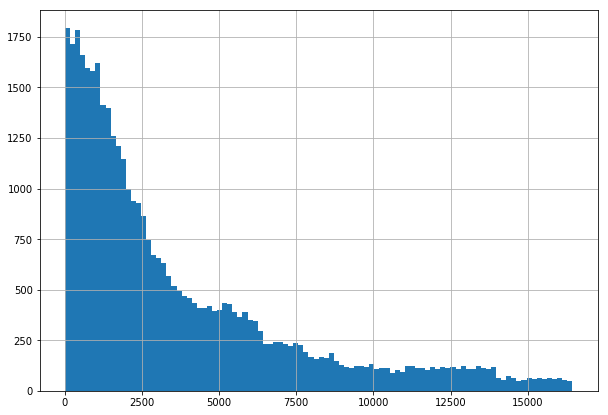

In [45]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

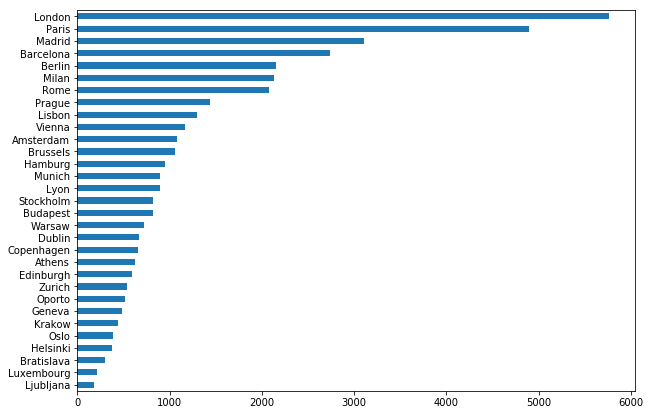

In [46]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

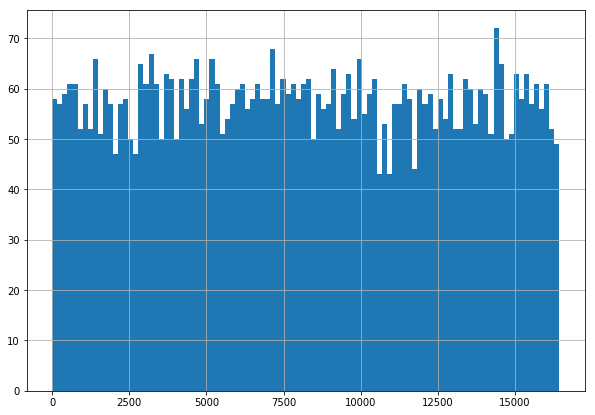

In [47]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

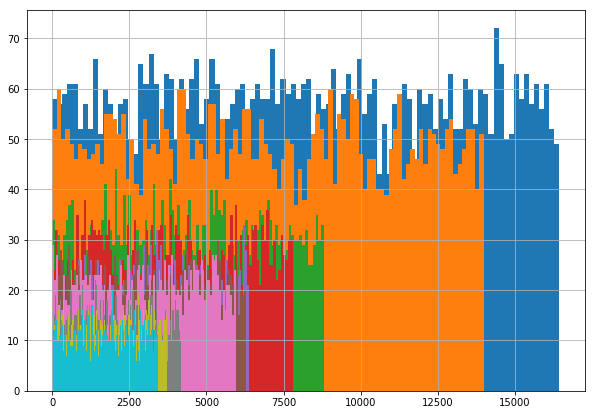

In [48]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

Разделим Ranking на количество ресторанов в городе и получим новый признак ranking_norm

In [49]:
data['ranking_norm'] = data.Ranking / data.rest_counts
data['ranking_norm']

0        2.122299
1        0.223158
2        1.087248
3        0.232031
4        0.097368
           ...   
49995    0.185598
49996    1.038147
49997    1.599226
49998    0.692973
49999    1.791759
Name: ranking_norm, Length: 50000, dtype: float64

### Посмотрим распределение целевой переменной

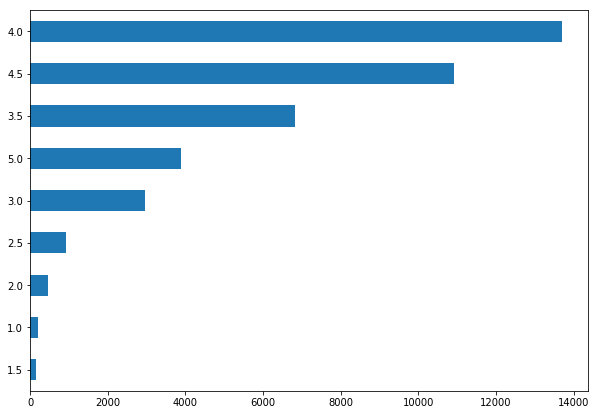

In [50]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

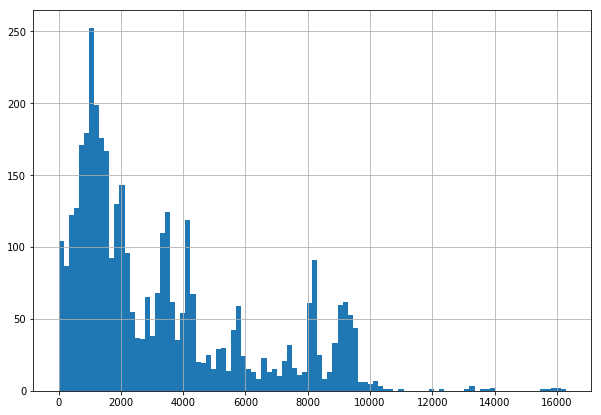

In [51]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

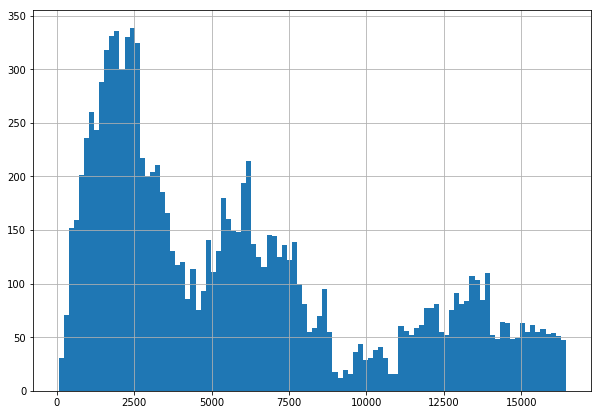

In [52]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

Посмотрим на корреляцию признаков 

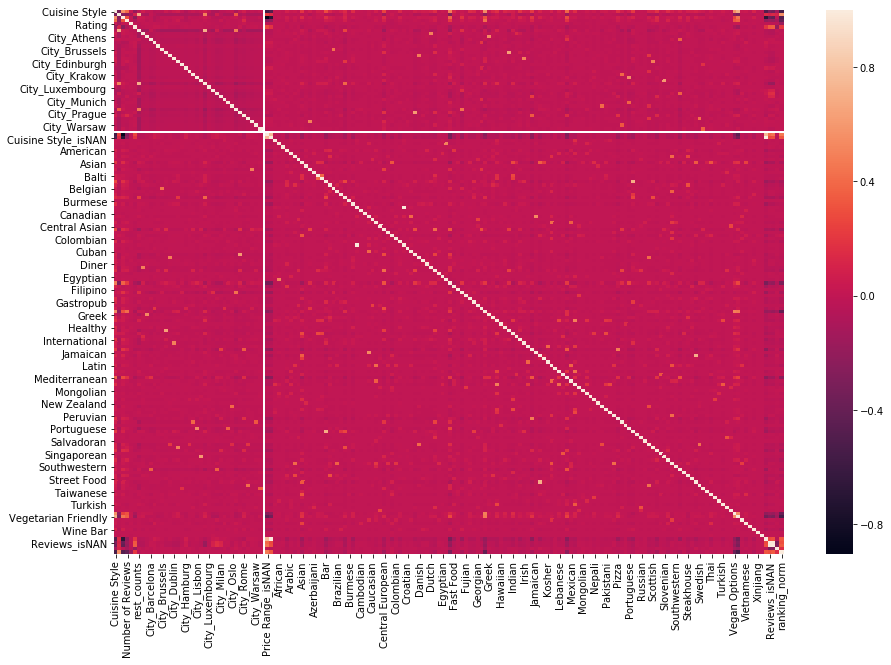

In [53]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [54]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [55]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
   
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски и создаем дополнительные признаки пропусков 
    df_output['Number_of_Reviews_isNAN'] = pd.isna(df_output['Number of Reviews']).astype('uint8')
    df_output['Price Range_isNAN'] = pd.isna(df_output['Price Range']).astype('uint8')
    df_output['Cuisine Style_isNAN'] = pd.isna(df_output['Cuisine Style']).astype('uint8')
    df_output['Reviews'] = df_output.Reviews.dropna().apply(lambda x: eval(x.replace('nan', '').replace('[,', "['',")))
    df_output['Reviews'] = df_output['Reviews'].dropna().apply(lambda x: np.nan if len(x[0]) == 0 & len(x[1]) == 0 else x)
    df_output['Reviews_isNAN'] = pd.isna(df_output['Reviews']).astype('uint8')
    
    df_output['Number of Reviews'].fillna(0, inplace=True)
    
    df_output['Price Range'] = df_output['Price Range'].fillna(0)  
    df_output['Cuisine Style'] = df_output['Cuisine Style'].fillna('indefined')
    
  
    city_counts_dict = dict(df_output['City'].value_counts())
    df_output['rest_counts'] = df_output.City.map(city_counts_dict)
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
   
    # Перкодируем Price Range в циферный признак 
    Price_range = {'$':1, '$$ - $$$':2, '$$$$':3}
    df_output['Price Range'] = df_output['Price Range'].replace(to_replace = Price_range)
    df_output['Price Range'].fillna(0)
    # Создаем из признака Cuisine Style dummi-признаки видов кухонь, сам признак Cuisine Style заменяем циферным количеством кухонь
    pat = re.compile('\w+\s*\w*\s*\w*')
    df_output['Cuisine Style'] = df_output['Cuisine Style'].dropna().apply(lambda x: ['default'] if pd.isnull(x) else pat.findall(x))
    df_output = df_output.join(pd.get_dummies(df_output['Cuisine Style'].apply(pd.Series).stack()).sum(level=0)) 
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: len(x))
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # Признак reviews, извлекаем из него даты отзывов и посчитаем разницу в днях 
    df_output['date'] = df_output['Reviews'].dropna().apply(lambda x: x[1])
    df_output['date_1'] = df_output['date'].dropna().apply(lambda x: x[1] if len(x) == 2 else np.nan)
    df_output['date_2'] = df_output['date'].dropna().apply(lambda x: x[0] if len(x) > 0 else np.nan)
    df_output.drop('date', axis=1, inplace=True)
    df_output['date_1'] = pd.to_datetime(df_output['date_1'])
    df_output['date_2'] = pd.to_datetime(df_output['date_2'])
    df_output['date_1'].fillna(df_output['date_1'].min(), inplace=True)
    df_output['date_2'].fillna(df_output['date_2'].max(), inplace=True)
    df_output['rewiew_days'] = abs(df_output['date_2'] - df_output['date_1']).dt.days
    df_output['days_to_today'] = (datetime.now() - df_output['date_2']).dt.days       
    # Создаем новый признак ranking_norm 
    df_output['ranking_norm'] = df_output.Ranking / data.rest_counts
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    df_output.drop(['date_1','date_2',], axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [56]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

AttributeError: 'DataFrame' object has no attribute 'rest_counts'

In [57]:
df_preproc.info()

NameError: name 'df_preproc' is not defined

In [58]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

NameError: name 'df_preproc' is not defined

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [59]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

NameError: name 'X' is not defined

In [60]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

NameError: name 'test_data' is not defined

# Model 
Сам ML

In [61]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [62]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [63]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

NameError: name 'X_train' is not defined

In [64]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

NameError: name 'y_test' is not defined

In [65]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

# Submission
Если все устраевает - готовим Submission на кагл

In [66]:
test_data.sample(10)

NameError: name 'test_data' is not defined

In [67]:
test_data = test_data.drop(['Rating'], axis=1)

NameError: name 'test_data' is not defined

In [68]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [69]:
predict_submission = model.predict(test_data)

NameError: name 'test_data' is not defined

In [70]:
predict_submission

NameError: name 'predict_submission' is not defined

In [71]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

NameError: name 'predict_submission' is not defined